In [2]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import albumentations as A
from tensorflow.keras.applications import EfficientNetB1
from keras.models import load_model

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
df = pd.read_csv(r'drive/My Drive/ASDRP/Experiments/simple-cnn-v3/df.csv')

In [5]:
df['gender'].value_counts()

1    2752
0    2248
Name: gender, dtype: int64

In [ ]:
df['race'].value_counts()

0    2682
2     834
3     720
4     542
1     222
Name: race, dtype: int64

In [6]:
import pickle
images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/list_of_tensors_generated.pickle", "rb"))

In [7]:
indices = []
#black_total = 222
#asian_total = 834
#indian_total = 720
#others_total = 542
female_total = 1313

for i in tqdm(range(len(df))):

  if df.iloc[i]['gender'] == 1 and df.iloc[i]['race'] != 0 and female_total > 500:
    indices.append(i)
    female_total -= 1



100%|██████████| 5000/5000 [00:00<00:00, 6167.38it/s]


In [ ]:
images_reduced = []

for i in range(len(images)):
  if i not in indices:
    images_reduced.append(images[i])

In [ ]:
len(images_reduced)

4187

In [8]:
race_dict = {'WM':0, 'BM': 0, 'AM': 0, 'IM': 0, 'OM': 0, 'WF':0, 'BF': 0, 'AF': 0, 'IF': 0, 'OF': 0}
for i in tqdm(range(len(df))):
  if df.iloc[i]['gender'] == 0:
    if df.iloc[i]['race'] == 0:
      race_dict['WM'] += 1
    if df.iloc[i]['race'] == 1:
      race_dict['BM'] += 1
    if df.iloc[i]['race'] == 2:
      race_dict['AM'] += 1
    if df.iloc[i]['race'] == 3:
      race_dict['IM'] += 1
    if df.iloc[i]['race'] == 4:
      race_dict['OM'] += 1
  else:
    if df.iloc[i]['race'] == 0:
      race_dict['WF'] += 1
    if df.iloc[i]['race'] == 1:
      race_dict['BF'] += 1
    if df.iloc[i]['race'] == 2:
      race_dict['AF'] += 1
    if df.iloc[i]['race'] == 3:
      race_dict['IF'] += 1
    if df.iloc[i]['race'] == 4:
      race_dict['OF'] += 1
  


100%|██████████| 5000/5000 [00:06<00:00, 720.84it/s] 


Text(0, 0.5, 'Number of examples in dataset')

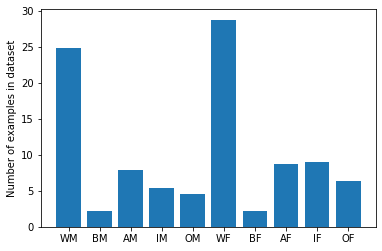

In [9]:
names = list(race_dict.keys())
values = list(race_dict.values())

for i in range(len(values)):
  values[i] /= 5000
  values[i] *= 100

plt.bar(range(len(race_dict)), values, tick_label=names)

plt.ylabel("Number of examples in dataset")

In [10]:
input_shape = (64, 64, 3)

In [11]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 7.2 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=4f290c3ef333a79f5eee49ada60f9ed5c9264c91068392f26c48615c468c4acd
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


In [12]:
import sys
import h5py
class TrainingDatasetLoader(object):
    def __init__(self, data_path):

        print ("Opening {}".format(data_path))
        sys.stdout.flush()

        self.cache = h5py.File(data_path, 'r')

        print ("Loading data into memory...")
        sys.stdout.flush()
        self.images = self.cache['images'][:]
        self.labels = self.cache['labels'][:].astype(np.float32)
        self.image_dims = self.images.shape
        n_train_samples = self.image_dims[0]

        self.train_inds = np.random.permutation(np.arange(n_train_samples))

        self.pos_train_inds = self.train_inds[ self.labels[self.train_inds, 0] == 1.0 ]
        self.neg_train_inds = self.train_inds[ self.labels[self.train_inds, 0] != 1.0 ]

    def get_train_size(self):
        return self.train_inds.shape[0]

    def get_train_steps_per_epoch(self, batch_size, factor=10):
        return self.get_train_size()//factor//batch_size

    def get_batch(self, n, only_faces=False, p_pos=None, p_neg=None, return_inds=False):
        if only_faces:
            selected_inds = np.random.choice(self.pos_train_inds, size=n, replace=False, p=p_pos)
        else:
            selected_pos_inds = np.random.choice(self.pos_train_inds, size=n//2, replace=False, p=p_pos)
            selected_neg_inds = np.random.choice(self.neg_train_inds, size=n//2, replace=False, p=p_neg)
            selected_inds = np.concatenate((selected_pos_inds, selected_neg_inds))

        sorted_inds = np.sort(selected_inds)
        train_img = (self.images[sorted_inds,:,:,::-1]).astype(np.float32)
        train_label = self.labels[sorted_inds,...]
        return (train_img, train_label, sorted_inds) if return_inds else (train_img, train_label)

    def get_n_most_prob_faces(self, prob, n):
        idx = np.argsort(prob)[::-1]
        most_prob_inds = self.pos_train_inds[idx[:10*n:10]]
        return (self.images[most_prob_inds,...]).astype(np.float32)

    def get_all_train_faces(self):
        return self.images[ self.pos_train_inds ]


In [ ]:
import h5py

h5f = h5py.File('/content/drive/MyDrive/ASDRP/Experiments/DB-VAE-UTKFace/train.h5', 'w')
h5f.create_dataset('images', data=images)
h5f.create_dataset('labels', data=loader_gender)
# h5f.create_dataset('test_images', data=X_test)
# h5f.create_dataset('test_labels', data=y_test)
# h5f.create_dataset('test_race', data=y_alias2)

h5f.close()

In [ ]:
loader_gender = np.reshape(y_gender, (len(y_gender),1))

In [15]:
loader = TrainingDatasetLoader('/content/drive/MyDrive/ASDRP/Experiments/DB-VAE-UTKFace/train.h5')

Opening /content/drive/MyDrive/ASDRP/Experiments/DB-VAE-UTKFace/train.h5
Loading data into memory...


In [ ]:
val_images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/test_tensors_generated.pickle", "rb"))

In [13]:
df_val = pd.read_csv('/content/drive/MyDrive/ASDRP/Experiments/df_test.csv')  

In [14]:
df_val

,image,age,gender,race
0,drive/My Drive/ASDRP/Experiments/test_data_rea...,2,1,2
1,drive/My Drive/ASDRP/Experiments/test_data_rea...,1,1,0
2,drive/My Drive/ASDRP/Experiments/test_data_rea...,76,1,0
3,drive/My Drive/ASDRP/Experiments/test_data_rea...,2,1,2
4,drive/My Drive/ASDRP/Experiments/test_data_rea...,5,1,0
...,...,...,...,...
995,drive/My Drive/ASDRP/Experiments/test_data_rea...,26,0,1
996,drive/My Drive/ASDRP/Experiments/test_data_rea...,9,0,1
997,drive/My Drive/ASDRP/Experiments/test_data_rea...,43,0,1
998,drive/My Drive/ASDRP/Experiments/test_data_rea...,90,0,1


In [ ]:
y_gender = np.array(df['gender'])
y_race = np.array(df['race'])
y_stack = np.vstack((y_gender,y_race))
Y = y_stack[0]

In [ ]:
y[:10]

5000

In [ ]:
y_gender[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
df

,image,age,gender,race
0,drive/My Drive/ASDRP/Data/utk_cropped/part1/20...,20,0,0
1,drive/My Drive/ASDRP/Data/utk_cropped/part1/21...,21,0,0
2,drive/My Drive/ASDRP/Data/utk_cropped/part1/18...,18,0,3
3,drive/My Drive/ASDRP/Data/utk_cropped/part1/31...,31,0,3
4,drive/My Drive/ASDRP/Data/utk_cropped/part1/12...,12,0,3
...,...,...,...,...
4995,drive/My Drive/ASDRP/Data/utk_cropped/part1/69...,69,1,0
4996,drive/My Drive/ASDRP/Data/utk_cropped/part1/57...,57,1,0
4997,drive/My Drive/ASDRP/Data/utk_cropped/part1/53...,53,1,0
4998,drive/My Drive/ASDRP/Data/utk_cropped/part1/59...,59,1,0


In [ ]:
test_indices = df.sample(n=837, random_state=40).index

In [ ]:
test_indices

Int64Index([4088, 2080,   41,  796,  354, 4183, 4292, 2346, 2764, 4949,
            ...
            2146, 3142, 3298, 1348, 3865, 2900, 1536, 3165, 2609,  892],
           dtype='int64', length=837)

In [ ]:
test_images = []
for i in test_indices.tolist():
  test_images.append(images_reduced[i])

IndexError: ignored

In [ ]:
len(test_indices.tolist())

837

In [16]:
len(images_reduced)

NameError: ignored

In [ ]:
images_reduced[0]

<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[0.620538  , 0.5970086 , 0.5421066 ],
        [0.64126843, 0.617739  , 0.56283706],
        [0.6569547 , 0.6334253 , 0.57852334],
        ...,
        [0.86274517, 0.8588236 , 0.8431373 ],
        [0.8647979 , 0.8491116 , 0.8373469 ],
        [0.8647979 , 0.8491116 , 0.8373469 ]],

       [[0.6432292 , 0.6196998 , 0.5647978 ],
        [0.6610601 , 0.6375307 , 0.5826287 ],
        [0.67674637, 0.65321696, 0.598315  ],
        ...,
        [0.8745099 , 0.8705883 , 0.854902  ],
        [0.86747044, 0.87282485, 0.853217  ],
        [0.86666673, 0.87282485, 0.853217  ]],

       [[0.65207714, 0.644234  , 0.5854105 ],
        [0.66908705, 0.6612439 , 0.6024204 ],
        [0.6769302 , 0.66908705, 0.6102635 ],
        ...,
        [0.87993264, 0.8862746 , 0.86666673],
        [0.87993264, 0.8862746 , 0.86666673],
        [0.87993264, 0.8862746 , 0.86666673]],

       ...,

       [[0.2295956 , 0.20606619, 0.11979167],
        [0.2103

In [ ]:
images_reduced = [i for j, i in enumerate(images_reduced) if j not in test_indices.tolist()]

In [ ]:
y_gender_test = np.array(df.iloc[test_indices]['gender'])

In [ ]:
Y = np.delete(Y, test_indices)

In [ ]:
images_reduced = np.array(images_reduced)
val_images = np.array(val_images)

In [ ]:
len(images_reduced)

3488

In [ ]:
Y = np.reshape(Y, (len(Y),1))


In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/ASDRP/Experiments/df_test.csv')  

In [ ]:
len(images)

5000

In [17]:
y_gender = np.reshape(y_gender, (len(y_gender),1))

NameError: ignored

In [ ]:
y_race = np.array(df_val['race'])

In [ ]:
y_race = np.reshape(y_race, (len(y_race),1))


In [ ]:
y_race[:10]

array([[0],
       [0],
       [3],
       [3],
       [3],
       [3],
       [0],
       [3],
       [3],
       [0]])

In [ ]:
y_gender[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
df

,image,age,gender,race
0,drive/My Drive/ASDRP/Data/utk_cropped/part1/20...,20,0,0
1,drive/My Drive/ASDRP/Data/utk_cropped/part1/21...,21,0,0
2,drive/My Drive/ASDRP/Data/utk_cropped/part1/18...,18,0,3
3,drive/My Drive/ASDRP/Data/utk_cropped/part1/31...,31,0,3
4,drive/My Drive/ASDRP/Data/utk_cropped/part1/12...,12,0,3
...,...,...,...,...
4995,drive/My Drive/ASDRP/Data/utk_cropped/part1/69...,69,1,0
4996,drive/My Drive/ASDRP/Data/utk_cropped/part1/57...,57,1,0
4997,drive/My Drive/ASDRP/Data/utk_cropped/part1/53...,53,1,0
4998,drive/My Drive/ASDRP/Data/utk_cropped/part1/59...,59,1,0


In [ ]:
len(y_race)

5000

In [ ]:
Y_val = np.array(df_val['gender'])

In [ ]:
len(y_gender)

5000

In [ ]:
import h5py

h5f = h5py.File('/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/train.h5', 'w')
h5f.create_dataset('images', data=images)
h5f.create_dataset('labels', data=y_gender)
# h5f.create_dataset('test_images', data=val_images)
# h5f.create_dataset('test_labels', data=Y_val)
# h5f.create_dataset('test_race', data=y_race)

h5f.close()

In [ ]:
### Define the CNN model ###
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from keras.models import Sequential, Model

input_shape = (64, 64, 3)
'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  inputs = Input((input_shape))
  # convolutional layers
  conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
  maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
  conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
  maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
  conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
  maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
  conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
  maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

  flatten = Flatten() (maxp_4)

  # fully connected layers
  dense_1 = Dense(256, activation='relu') (flatten)
  #dense_2 = Dense(256, activation='relu') (flatten)
  #dense_3 = Dense(256, activation='relu') (flatten)

  dropout_1 = Dropout(0.3) (dense_1)
  #dropout_2 = Dropout(0.3) (dense_2)
  #dropout_3 = Dropout(0.3) (dense_3)

  output_1 = Dense(n_outputs, activation='sigmoid', name='gender_out') (dropout_1)
  #output_2 = Dense(1, activation='softmax', name='race_out') (dropout_2)
  #output_3 = Dense(1, activation='relu', name='age_out') (dropout_3)

  model = Model(inputs=[inputs], outputs=[output_1])

  model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])
  
  return model
standard_classifier = make_standard_classifier()

In [ ]:
len(Y)

5000

In [ ]:
len(images)

5000

In [ ]:
images = np.array(images)

In [ ]:
images.shape

(5000, 64, 64, 3)

In [ ]:
images[0].shape

(64, 64, 3)

In [ ]:
type(Y)

numpy.ndarray

In [ ]:
type(images)

numpy.ndarray

In [ ]:
Y = np.reshape(Y, (len(Y),1))

In [ ]:
print(type(Y[0][0]))

<class 'numpy.int64'>


In [ ]:
len(Y_val)

1000

In [ ]:
type(y_gender)

numpy.ndarray

In [ ]:
Y_val

['drive/My Drive/ASDRP/Experiments/test_data_real/part1/2_1_2_20161219202547820.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/1_1_0_20170109190844250.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/76_1_0_20170110131744527.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/2_1_2_20161219152918020.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/5_1_0_20170109194229104.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/17_0_0_20170104003852806.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/46_0_3_20170104210508188.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/1_1_4_20170103210113314.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/8_1_0_20170109203557851.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/1_0_2_20161219155850477.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/part1/30_1_0_20170104165921257.jpg',
 'drive/My Drive/ASDRP/Experiments/test_data_real/

In [ ]:
history = standard_classifier.fit(x=images, y=y_gender, batch_size=32, epochs=50, validation_data=(val_images, Y_val))

Epoch 1/50
157/157 [==============================] - 2s 11ms/step - loss: 0.5880 - accuracy: 0.6754 - val_loss: 0.5854 - val_accuracy: 0.6880
Epoch 2/50
157/157 [==============================] - 1s 9ms/step - loss: 0.5449 - accuracy: 0.7044 - val_loss: 0.5828 - val_accuracy: 0.6920
Epoch 3/50
157/157 [==============================] - 2s 11ms/step - loss: 0.5038 - accuracy: 0.7412 - val_loss: 0.5537 - val_accuracy: 0.7070
Epoch 4/50
157/157 [==============================] - 2s 12ms/step - loss: 0.4558 - accuracy: 0.7812 - val_loss: 0.5786 - val_accuracy: 0.7110
Epoch 5/50
157/157 [==============================] - 1s 9ms/step - loss: 0.4007 - accuracy: 0.8090 - val_loss: 0.6127 - val_accuracy: 0.7010
Epoch 6/50
157/157 [==============================] - 1s 9ms/step - loss: 0.3307 - accuracy: 0.8498 - val_loss: 0.6695 - val_accuracy: 0.7000
Epoch 7/50
157/157 [==============================] - 1s 8ms/step - loss: 0.2598 - accuracy: 0.8842 - val_loss: 0.8098 - val_accuracy: 0.6830
Epo

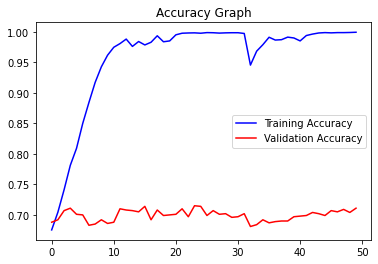

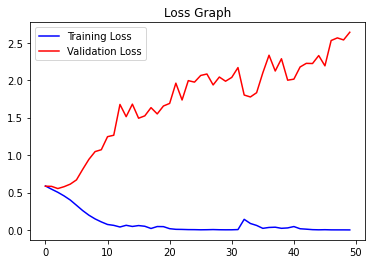

In [ ]:
# plot results for gender
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

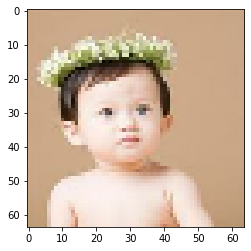

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(val_images[0], interpolation='nearest')
plt.show()

In [ ]:
Y_val = [a for a in tqdm(df_val.image)]

100%|██████████| 1000/1000 [00:00<00:00, 1145984.70it/s]


In [ ]:
test_images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/test_tensors_generated.pickle", "rb"))
test_images = np.array(test_images)

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/ASDRP/Experiments/df_test.csv')  

In [ ]:
predictions_gender = []
for i in tqdm(test_images):
  pred = standard_classifier.predict(i.reshape(1, 64, 64, 3))
  pred_gender = round(pred[0][0])

  predictions_gender.append(pred_gender)

100%|██████████| 1000/1000 [00:53<00:00, 18.76it/s]


In [ ]:
y_gender_test = np.array(df_test['gender'])

In [ ]:
def get_accuracy_both(race, gender):
  correct = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender: 
      correct += 1
    if df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender:
      total += 1
    #if df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender and df_test.iloc[i]['age'] >= age_start and df_test.iloc[i]['age'] <= age_end:
    #  total += 1

    #  and df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender and df_test.iloc[i]['age'] >= age_start and df_test.iloc[i]['age'] <= age_end
  
  return correct / total

def get_accuracy_race(race):
  correct = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['race'] == race: 
      correct += 1
    if df_test.iloc[i]['race'] == race:
      total += 1
  
  return correct / total

def get_accuracy_gender(gender):
  correct = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['gender'] == gender: 
      correct += 1
    if df_test.iloc[i]['gender'] == gender:
      total += 1
  
  return correct / total

def get_accuracy_overall():
  correct = 0
  total = 837
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i]: 
      correct += 1
  
  return correct / total

def get_false_positive(race):
  false_positives = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == 1 and y_gender_test[i] == 0 and df_test.iloc[i]['race'] == race: 
      false_positives += 1
    if df_test.iloc[i]['race'] == race:
      total += 1
  
  return false_positives / total

def get_false_negative(race):
  false_negatives = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == 0 and y_gender_test[i] == 1 and df_test.iloc[i]['race'] == race: 
      false_negatives += 1
    if df_test.iloc[i]['race'] == race:
      total += 1
  
  return false_negatives / total

In [ ]:
get_accuracy_overall()

0.7120669056152927

In [ ]:
len(y_race)

1000

In [ ]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  # latent_loss = # TODO

  # TODO: Define the reconstruction loss as the mean absolute pixel-wise 
  # difference between the input and reconstruction. Hint: you'll need to 
  # use tf.reduce_mean, and supply an axis argument which specifies which 
  # dimensions to reduce over. For example, reconstruction loss needs to average 
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  # reconstruction_loss = # TODO

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  # vae_loss = # TODO
  
  return vae_loss

In [ ]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
  # z = # TODO
  return z


In [ ]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # TODO: call the relevant function to obtain VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  # vae_loss = vae_loss_function('''TODO''') # TODO

  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  # classification_loss = # TODO

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the DB-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  total_loss = tf.reduce_mean(
      classification_loss + 
      face_indicator * vae_loss
  )
  # total_loss = # TODO

  return total_loss, classification_loss

In [ ]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  ### Define the CNN model ###
  inputs = Input((input_shape))
  # convolutional layers
  conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
  maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
  conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
  maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
  conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
  maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
  conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
  maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

  flatten = Flatten() (maxp_4)

  # fully connected layers
  dense_1 = Dense(256, activation='relu') (flatten)
  #dense_2 = Dense(256, activation='relu') (flatten)
  #dense_3 = Dense(256, activation='relu') (flatten)

  dropout_1 = Dropout(0.3) (dense_1)
  #dropout_2 = Dropout(0.3) (dense_2)
  #dropout_3 = Dropout(0.3) (dense_3)

  output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
  #output_2 = Dense(1, activation='softmax', name='race_out') (dropout_2)
  #output_3 = Dense(1, activation='relu', name='age_out') (dropout_3)

  model = Model(inputs=[inputs], outputs=[output_1])

  
  return model

In [ ]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='sigmoid')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

In [ ]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma)
    # z = # TODO
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z)
    # reconstruction = # TODO
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma)
    # z = # TODO

    # TODO: reconstruction
    recon = self.decode(z)
    # recon = # TODO
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

In [ ]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

In [ ]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae)
    # mu = get_latent_mu('''TODO''') # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        # TODO: call the digitize function to find which bins in the latent distribution 
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges)
        # bin_idx = np.digitize('''TODO''', '''TODO''') # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # TODO: normalize all probabilities
        p = p / np.sum(p)
        # p = # TODO
        
        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p)
        # training_sample_p = # TODO
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [ ]:
loader.labels.shape

(5000, 1)

In [ ]:
### Training the DB-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 100  

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
    # loss, class_loss = debiasing_loss_function('''TODO arguments''') # TODO
  
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, dbvae.trainable_variables)
  # grads = tape.gradient('''TODO''', '''TODO''') # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae)
  # p_faces = get_training_sample_probabilities('''TODO''', '''TODO''') # TODO
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

Starting epoch 1/100
Recomputing the sampling probabilities


  0%|          | 0/156 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
a = tf.round(tf.nn.sigmoid(dbvae.predict(test_images)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(y_gender_test, a), tf.float32))

print("Standard CNN accuracy on (potentially biased) testing set: {:.4f}".format(acc_standard.numpy()))

Standard CNN accuracy on (potentially biased) testing set: 0.4984


In [ ]:
print(tf.nn.sigmoid(dbvae.predict(test_images[0:100])))

tf.Tensor(
[[0.5       ]
 [0.5130564 ]
 [0.7197844 ]
 [0.5026052 ]
 [0.51242435]
 [0.5       ]
 [0.5       ]
 [0.5       ]
 [0.51028323]
 [0.5       ]
 [0.5       ]
 [0.73068726]
 [0.5       ]
 [0.5004397 ]
 [0.50003463]
 [0.5       ]
 [0.50018126]
 [0.73105854]
 [0.5000059 ]
 [0.5       ]
 [0.5       ]
 [0.5       ]
 [0.5       ]
 [0.5000018 ]
 [0.5       ]
 [0.5       ]
 [0.73105854]
 [0.5       ]
 [0.5       ]
 [0.73105854]
 [0.5000003 ]
 [0.5       ]
 [0.5       ]
 [0.73105854]
 [0.7310466 ]
 [0.5       ]
 [0.73105854]
 [0.5       ]
 [0.50000656]
 [0.5       ]
 [0.73105854]
 [0.5       ]
 [0.73105854]
 [0.73105854]
 [0.50000155]
 [0.73105854]
 [0.5       ]
 [0.73105824]
 [0.73046684]
 [0.5       ]
 [0.5002615 ]
 [0.5       ]
 [0.5000016 ]
 [0.5       ]
 [0.5       ]
 [0.5000264 ]
 [0.7307363 ]
 [0.50000286]
 [0.5000217 ]
 [0.5       ]
 [0.73105854]
 [0.5       ]
 [0.50000113]
 [0.52123547]
 [0.73105854]
 [0.5       ]
 [0.5       ]
 [0.50000024]
 [0.7310552 ]
 [0.5000003 ]
 [0.5    